In [4]:
%matplotlib inline


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld
import musdb
from IPython.display import Audio
from scipy import stats
import soundfile as sf
import sox
import pandas as pd
import os
import mir_eval

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "arial",
    "font.size": 31,
    "axes.labelsize": 'medium'})

In [106]:
def data_dict(tipo, mistura,algoritmo,nfontes,A, W,rate = None, white= None, amari = None, correlacao= None, corr_media = None,
         mses= None,mse_media = None, sdr=None, sir=None ,sar=None, sdr_media = None, sar_media = None, sir_media = None): 
    data_dict = {'Tipo':tipo, 'Mistura': mistura,'Algoritmo': algoritmo, 'Número de Fontes':nfontes,
                 'Matriz de mistura': A,'Matriz de separacao':W,
                 'Learning Rate':rate, 'White':white,
                 'Indice de Amari': amari,'Correlacao': correlacao,'Correlacao Media': corr_media,
                 'MSE': mses,'Media EQM': mse_media, 'SDR': sdr, 'SIR': sir, 'SAR': sar, 'SDR Media': sdr_media, 
                'SAR Media': sar_media, 'SIR Media': sir_media}
    #data_dict = {'Tipo':tipo, 'Mistura': mistura,'Algoritmo': algoritmo, 'Número de Fontes':nfontes,'Learning Rate':rate, 'White':white,
                 #'Índice de Amari': amari,'Correlacao': correlacao,'MSE': mses, 'SDR': sdr, 'SIR': sir, 'SAR': sar}
    return data_dict

In [7]:
#def source_dict(tipo, mistura, nfontes, s1kurt, s2kurt, s3kurt, s4kurt)

In [8]:
def save_data_csv(data_dict,create = False, path_to_csv = None):
    try:
        df = pd.read_csv(path_to_csv)
        df = df.append(data_dict, ignore_index = True)
        df.to_csv(path_to_csv, index = False)
    except(FileNotFoundError):
        if create:
            df = pd.DataFrame(columns = data_dict.keys())
            df = df.append(data_dict, ignore_index = True)
            df.to_csv(path_to_csv, index = False)
        else:
            raise('DataFrame não encontrado!')
    return df

In [9]:
def preprocess(tipo, arquivo):
    tfm = sox.Transformer()
    tfm.norm()
    tfm.rate(22050)
    pathold = 'E:/Audios/Antigos/'+tipo+arquivo
    pathnorm = 'E:/Audios/Novos/'+tipo+arquivo
    tfm.build_file(pathold+'/source1.wav', pathnorm+'/source1.wav')
    tfm.build_file(pathold+'/source2.wav', pathnorm+'/source2.wav')
    tfm.build_file(pathold+'/source3.wav', pathnorm+'/source3.wav')
    tfm.build_file(pathold+'/source4.wav', pathnorm+'/source4.wav')

In [10]:
def load(path, arquivo):
    """Carrega 4 arquivos de áudio localizados em pathmix."""
    
    pathmix = path+arquivo
    nome1 = pathmix+'/source1.wav'
    nome2 = pathmix+'/source2.wav'
    nome3 = pathmix+'/source3.wav'
    nome4 = pathmix+'/source4.wav'
    s1, sr = librosa.load(nome1, duration = 10)
    s2, sr = librosa.load(nome2, duration = 10)
    s3, sr = librosa.load(nome3, duration = 10)
    s4, sr = librosa.load(nome4, duration = 10)
    return s1,s2,s3,s4,sr

In [11]:
def whitening(X):
    """Realiza o branqueamento dos dados em X, retornando os dados branqueados em z junto 
    da matriz de branqueamento em Wwhite."""
    
    Xm = X - X.mean()
    covXm = np.cov(Xm)
    evalor, evetor = np.linalg.eig(covXm)
    wevalor = np.diag(1/(evalor**0.5))
    Wwhite = wevalor.dot(evetor.T) #matriz de branqueamento
    z = np.dot(Wwhite,Xm)
    return z, Wwhite

In [12]:
def normaliza(v):
    """Normaliza os dados recebidos."""

    vn = [k/np.std(k) for k in v]
    return np.array(vn)

In [113]:
def correlacao(Sn, Yn):
    """Realiza o cálculo da correlação de Pearson e separa os pares de maior correlação
    entre sinais originais e sinais estimados
    
    Parâmetros
    -----------------------------
    Sn: array
        Sinais originais normalizados
    Yn: array
        Sinais estimados normalizados
    
    Retorna
    -----------------------------
    allarrays: list 
        Lista contendo duas tuplas, a primeira com os pares de maior correlação, e a segunda com o índice
    de cada componente deste par. Exemplo: [(Sinal1, Sinal4), (0,3)]
    """
    
    allarrays = list()
    for p in range (0,len(Sn)): #Para comparar com S[0] e S[1]
        corrnova = 0
        corr = 0
        arrays = list()
        for o in range(0,len(Sn)): #Para comparar com Yn[0] e Yn[1]
            corrnova = stats.pearsonr(Sn[p],Yn[o])
           # print(f'Correlação de Pearson vale {stats.pearsonr(Sn[p], Yn[o])[0]} entre a {p+1} linha de S e a {o+1} linha de Y')
            if np.abs(corrnova[0]) > np.abs(corr): 
                corr = corrnova[0]
                arrays.clear()
                if corr < 0:
                    Yn[o] = Yn[o] * -1
                arrays.append(((Sn[p], Yn[o]),(p,o)))
        allarrays.append(arrays)
    return allarrays 
#Sn[p] e Y[o] são os pares de componentes com maior correlação
#retorna o vetor com os pares de maior correlaçao acompanhado de uma tupla (p,o) em que p é a posiçao de S[p] e o é a posição de Y[o]

In [112]:
def mse(pares, X):
    """Calcula o erro quadrático médio para pares de dados.
    
    Parâmetros
    -----------------------------
    pares: Lista contendo duas tuplas, sendo a primeira um par de variáveis e a segunda o índice dessas variáveis.
    
    Retorna
    -----------------------------
    mseall: Lista com o erro quadrático médio para cada par de dados.
    """
    
    mseall = list()
    msgrafs = list()
    for x in pares:
        mse = 0
        msgraf = list()
        for ponto in range (0, X.shape[1]):
            sqr = (x[0][0][0][ponto]- x[0][0][1][ponto])**2
            msgraf.append(sqr)
            mse += sqr
        msgrafs.append(msgraf)
        mse = mse/X.shape[1]
        posicao = x[0][1] #guarda posiçao das linhas de maior correlaçao
        mseall.append((mse, posicao))
    #for z in mseall:
       # print(f'O erro quadrático médio entre a {(z[1][0])+1}ª linha de S e a {(z[1][1])+1}ª linha de Y é de {z[0]}')
    return mseall, msgrafs
#retorna array com o erro quadratico medio e suas posições correspondentes 

In [15]:
def amari2(W, A):
    """Calcula o índice de amari para W e A """
    p = W.dot(A)
    C= D = 0
    for c in range(len(W)):
        a = b = 0
        for d in range(len(W)):
            a += (np.abs(p[c][d])/np.max(np.abs(p[c,:])))
            b += (np.abs(p[d][c])/np.max(np.abs(p[:,c])))
        C += a-1
        D += b-1
    E = C+D
    print(f'O índice de Amari obtido para W é de {E}')
    return E

In [16]:
def grafmse(nome, msegrafs, Sn, Yn, mistura, tipo):
    for graf in range (0, len(msegrafs)):
        plt.figure(figsize = (14,5))
        #plt.title(f'{tipo} - {mistura} - MSE S e Y - {nome} ({graf+1}/{len(msegrafs)})')
        #plt.title(f'Erro quadrático médio')
        plt.xlim(0,len(Sn[0]))
        plt.ylim(0,  max(msegrafs[graf]))
        plt.plot(msegrafs[graf], color = 'cornflowerblue')

In [17]:
def grafsinais(nome, mseall, Sn, Yn, mistura, tipo):
    """Plota os gráficos comparativo entre os sinais.
    
    Parâmetros
    -----------------------------
    pares: Lista contendo duas tuplas, sendo a primeira um par de variáveis e a segunda o índice dessas variáveis.
    """
    fig = plt.figure(figsize=(14,5))
    pos_i = len(Sn)*100+10
    for num, a in  enumerate(mseall):
        pos = pos_i+(num+1)
        atual = str(num+1) #indice da fonte atual
        total = str(len(mseall)) #número total de fontes
        indexS = a[1][0]
        indexY = a[1][1]
        a =fig.add_subplot(pos)
        plt.title(f'{tipo} - {mistura} - Comparação sinais S e Y - {nome} ({atual}/{total})')
        a.plot(Sn[indexS])
        a.plot(Yn[indexY])
        plt.legend(['Sinal Original', 'Sinal Separado'], loc = 'lower left')

In [121]:
def curtose(a, w, z, rate= 0, tipo = None):
    """Calcula a matriz de mistura com o algoritmo FastICA com curtose.
    
    Parâmetros
    -----------------------------
    w: Matriz de separação inicial.
    z: Sinal misturado branco.
    
    Retorna
    -----------------------------
    nome: Nome do algoritmo utilizado
    W: Matriz de separação
    """
    
    nome = "FastICA por Curtose"
    wlist = list()
    m = len(z)
    want = 0
    cont = 0
    for p in range (1, m+1):
        w1 = w_i[:,p-1]
        while True:
            w1 = (((w1.T.dot(z)**3).dot(z.T)).T/z.shape[1])-3*w1
            w1 = w1/np.linalg.norm(w1)
            cont += 1
            if cont >= 2:
                want = w1
                if np.allclose(w1, want, atol = 0.000001):
                    break
            cont += 1  
        if p > 1:
            for j in range(1, p):
                a = w1.T.dot(wlist[j-1])
                w1 = w1 - (a*wlist[j-1])
            w1 = w1/np.linalg.norm(w1)
        wlist.append(w1)
    W = list()
    for o in wlist:
        wfinal = list()
        for numP, p in enumerate(o):
            print(p)
            nw= p
            wfinal.append(nw)
            if numP == len(o)-1:
                W.append(wfinal)            
    W = np.array(W)
    print(f'Número de iterações: {cont}')
    return nome, W, cont

In [122]:
#Algoritmo de FastICA com negentropia
def negentropia(A, w_i, z, rate = 0, tipo = None):
    """Calcula a matriz de separação com o algoritmo FastICA com negentropia.
    
    Parâmetros
    -----------------------------
    w: Matriz de separação inicial.
    z: Sinal misturado branco.
    
    Retorna
    -----------------------------
    nome: Nome do algoritmo utilizado
    W: Matriz de separação
    """
    
    nome = "FastICA por Negentropia"
    wlist = list()
    amaris = list()
    m = len(z)
    want = 0
    cont = 0
    for p in range (1, m+1):
        w = w_i[:,p-1]
        while True:
            w = (z.dot((np.tanh(w.T.dot(z)).T)))/z.shape[1] - (np.sum((1-(np.tanh(w.T.dot(z))**2))/z.shape[1])*w)
            w = w/np.linalg.norm(w)
            cont += 1
            if cont >= 2:
                want = w
                if np.allclose(w, want, atol = 0.000001):
                    break
        if p > 1:
            for j in range(1, p):
                a = w.T.dot(wlist[j-1])
                w = w- (a*wlist[j-1])
            w = w/np.linalg.norm(w)
           # amr = amari2(a,w)
           # amaris.append(amr)
        wlist.append(w)
    W = list()
    for o in wlist:
        wfinal = list()
        for numP, p in enumerate(o):
            nw= p
            wfinal.append(nw)
            if numP == len(o)-1:
                W.append(wfinal)            
    W = np.array(W)
    print(f'Número de iterações: {cont}')
    return nome, W, cont

In [20]:
def amr_graf(amaris):
    plt.plot(amaris)

In [110]:
#Algoritmo Infomax
def infomax(a, W, X, rate, tipo = 'super'):
    """Calcula a matriz de separação com o algoritmo Infomax
    
    Parâmetros
    -----------------------------
    W: array
        Matriz de separação inicial
    X: array
        Mistura de sinais
    rate: float
        Taxa de aprendizagem
 
    tipo : str
        Define qual variação do algoritmo será utilizada (sup/super/extended)
        
    Retorna
    -----------------------------
    nome: str 
        Nome do algoritmo utilizado
    W: array
        Matriz de separação
    """
    
    lenght_X = len(X)
    Wlist = list()
    nome = "Infomax " + tipo
    I = np.eye(lenght_X, lenght_X)
    cont = None
    for k in range (0,X.shape[1]):
        y = W.dot(X[:,k])
        if tipo == 'super':
            fy = np.array([np.tanh(y[m]) for m in range (lenght_X)])
        elif tipo == 'sub':
            fy = np.array([y[m] - np.tanh(y[m]) for m in range (lenght_X)])
        W = W + rate*np.dot((I-np.outer(fy,y)),(W))
        Wlist.append(W)
    #for i in range(0, W.shape[0]):
     #   w_pesos = list()
     #   for p in Wlist:
        #    w_pesos.append(p[i])
       # plt.figure()
      #  plt.plot(w_pesos)
    return nome, W, cont

In [102]:
def teste(tipo, mistura ,S, X, algoritmo, w, A,save = False, rate = 0.001, white = False , tipoinfomax = 'super', path_to_csv = None):
    """Aplica o ICA em uma determinada mistura de acordo com o algoritmo desejado
    
    Parâmetros
    -----------------------------
    S: array 
        Sinais originais
    X: array
        Sinais misturados
    algoritmo: função
        nome da função do algoritmo desejado
    w: array
        matriz de separação inicial
    A: array 
        Matriz de mistura
    rate: float 
        taxa de aprendizagem
    white: Bool
        False caso não se deseje fazer o branqueamento da mistura
        
    Retorna
    -----------------------------
    Yn: array
        Sinais estimados
    
    """
    try:
        Sn = normaliza(S)
        nfontes = len(Sn)
        if white:
            X, wwhite = whitening(X)
        nome, W, steps = algoritmo(A, w, X, rate, tipo = tipoinfomax)
        try:
            y = W.dot(X)
        except(ValueError):
            y = np.transpose(W).dot(X)
        print(f'Nome do algoritmo: {nome}')
        Yn = normaliza(y)
        if white:
            W = W.dot(wwhite)
        amari = amari2(W,A)
        pares = correlacao(Sn,Yn)
        correlacoes = [stats.pearsonr(a[0][0][0], a[0][0][1])[0] for a in pares]
        corr_media = correqm_mean(correlacoes)
        mses, graf_mse = mse(pares, X)
       # grafmse(nome, graf_mse, Sn, Yn, mistura)
       # grafsinais(nome, mses, Sn, Yn, mistura)
        eqm_vect = [eqm[0] for eqm in mses]
        eqm_media = correqm_mean(eqm_vect) 
        sdr, sir, sar, perm= mir_eval.separation.bss_eval_sources(Sn, Yn, compute_permutation = True)
        sdr_media =correqm_mean(sdr)
        sar_media =correqm_mean(sar)
        sir_media =correqm_mean(sir)
        #print(f'SDR: {sdr}\nSIR: {sir}\nSAR: {sar}')
        A_dict = A.reshape(1,A.shape[0]*A.shape[1])
        W_dict = W.reshape(1, A.shape[0]*W.shape[1])
        A_dict = A_dict[0]
        W_dict = W_dict[0]
        if save == True:
            ddict = data_dict(tipo, mistura,nome,nfontes, A_dict, W_dict,rate, white, amari, correlacoes,corr_media,eqm_vect,
                              eqm_media,sdr,sir, sar, sdr_media, sar_media, sir_media)
            save_data_csv(ddict, create = True, path_to_csv = path_to_csv)
        print()
        return Yn, pares
    except:
        if save == True:
            ddict = data_dict(tipo, mistura,nome,nfontes, A_dict, W_dict,rate)
            save_data_csv(ddict, create = True, path_to_csv = path_to_csv)
        print('Algoritmo não rodou com sucesso')
        pass

In [119]:
def simula(tipo, pre_process = True, save = False, path_to_csv = None):
    """Função para realizar as simulações, variando a mistura de fontes e o número de fontes a ser analisado.
        
    Parâmetros
    -----------------------------
    tipo : str
        tipo de fontes a ser utilizado
    pre_process : bool
        define se o pré processamento deverá ser realizado
    """
    for numero in range(1,6):
        tipo1 = tipo+'/'
        num = str(numero)
        arquivo = "Mistura"+num
        path = 'E:/Audios/Novos/'+tipo1
        
        try:
            s1, s2, s3, s4, sr = load(path, arquivo)
        except(FileNotFoundError):
            if pre_process:
                preprocess(tipo,arquivo)
                s1, s2, s3, s4, sr = load(path, arquivo)
            else:
                raise('Path não existe!')

        Slist = [s1, s2]
        for n_sources in range(2,4):
            print(f'Número de fontes: {n_sources}')
            S = np.array(Slist)
            lenght_S = len(S)
            A = np.random.randn(lenght_S, lenght_S)
            X = A.dot(S)
            #w = np.random.randn(len(X), 1)
            #w = w/np.linalg.norm(w)
            #winfomax = np.random.randn(lenght_S, lenght_S)
            w = np.identity(len(S))
            teste(tipo, arquivo, S, X, curtose, w,A, save= True, white = True, path_to_csv = path_to_csv)
            teste(tipo, arquivo, S, X, negentropia, w, A,save = True, white = True, path_to_csv = path_to_csv)
            teste(tipo,arquivo, S, X, infomax, w, A, save = True, rate = 0.001, white=False, tipoinfomax = 'super', path_to_csv = path_to_csv)
            teste(tipo, arquivo, S, X, infomax, w, A,  save = True, rate = 0.001, white=False, tipoinfomax = 'sub', path_to_csv = path_to_csv)
           # print(mne.preprocessing.infomax(X))
            if n_sources == 2:
                Slist.append(s3)
            if n_sources == 3:
                Slist.append(s4)

In [104]:
def correqm_mean(correlacoes_eqms): #media de correlacoes OU eqm
    sum_corr = 0
    for corr_it in range(0, len(correlacoes_eqms)):
        sum_corr+=abs(correlacoes_eqms[corr_it])
    mean_c = sum_corr/len(correlacoes_eqms)
    return mean_c

In [120]:
simula('vehicle', save = True, path_to_csv = 'AA.csv')

Número de fontes: 2
[[-0.00719044  0.04283042]
 [-0.09873883  0.99021673]]
[-0.12242067  0.55356072]
[-0.03702748  0.82292932]
[0.05544936 0.55554036]
[0.01615867 0.82948127]
Número de iterações: 4
Nome do algoritmo: FastICA por Curtose
O índice de Amari obtido para W é de 1.526553814820467

Número de iterações: 3
Nome do algoritmo: FastICA por Negentropia
O índice de Amari obtido para W é de 0.6015415379460813

Nome do algoritmo: Infomax super
O índice de Amari obtido para W é de 3.383008904474512

Nome do algoritmo: Infomax sub
O índice de Amari obtido para W é de 0.5263914837897541

Número de fontes: 3
[[-3.71944134e-04 -1.02315052e-05 -8.48490480e-05]
 [-1.03355096e-05 -7.12738141e-04  3.69283724e-04]
 [ 3.40821808e-04 -1.56784883e-03  9.97685253e-01]]
[[ 9.25349025e-05  2.54519265e-06  2.11087850e-05]
 [ 2.57638954e-06  1.77498487e-04 -9.20157651e-05]
 [ 3.41225229e-04 -1.59340611e-03  9.97810850e-01]]
[[-2.31017590e-05 -6.41743005e-07  2.11927507e-05]
 [-6.43072170e-07 -4.4123812


Número de iterações: 4
Nome do algoritmo: FastICA por Negentropia
O índice de Amari obtido para W é de 0.6857876231961773

Nome do algoritmo: Infomax super
O índice de Amari obtido para W é de 2.847726770779613

Nome do algoritmo: Infomax sub
O índice de Amari obtido para W é de 3.815576501980699



In [118]:
pd.read_csv('AA.csv')

,Tipo,Mistura,Algoritmo,Número de Fontes,Matriz de mistura,Matriz de separacao,Learning Rate,White,Indice de Amari,Correlacao,Correlacao Media,MSE,Media EQM,SDR,SIR,SAR,SDR Media,SAR Media,SIR Media
0,vehicle,Mistura1,FastICA por Curtose,2,[-0.5934804 -0.27748591 -0.51015037 -0.72911832],[-96.50447959 37.02162947 -18.05980879 5.88...,0.001,True,0.597371,"[-0.9998932739538422, 0.24477496320991515]",0.622334,"[3.99979218090119, 1.5104811396617441]",2.755137,[ 36.10922999 -11.80264563],[ 36.71904306 -11.80250083],[44.93736955 45.04792326],23.955938,44.992646,24.260772
1,vehicle,Mistura1,FastICA por Negentropia,2,[-0.5934804 -0.27748591 -0.51015037 -0.72911832],[-96.70207958 36.94874788 -25.89752091 30.07...,0.001,True,0.012550,"[0.9999738826081058, 0.9999997495601227]",0.999987,"[8.4528035157074e-05, 6.587501659379962e-07]",0.000043,[40.74232604 61.82024257],[42.82582226 63.00421238],[44.93264864 68.04322595],51.281284,56.487937,52.915017
2,vehicle,Mistura1,Infomax super,2,[-0.5934804 -0.27748591 -0.51015037 -0.72911832],[ 14.87297981 15.37766257 -67.1290496 50.84...,0.001,False,3.339104,"[0.39010454210152096, 0.9607084994690106]",0.675407,"[1.2197917025798122, 0.07858328465542382]",0.649187,[-7.33135063 10.79488438],[-7.33135063 10.79488438],[152.04534589 152.00618291],9.063118,152.025764,9.063118
3,vehicle,Mistura1,Infomax sub,2,[-0.5934804 -0.27748591 -0.51015037 -0.72911832],[ 59.2275152 -26.93917037 -36.70347387 48.04...,0.001,False,0.516233,"[-0.9307458386260372, 0.999119083204947]",0.964932,"[3.861497534450324, 0.0017618379708633943]",1.931630,[ 8.13765384 27.54402146],[ 8.13765384 27.54402146],[151.99461125 152.02667884],17.840838,152.010645,17.840838
4,vehicle,Mistura1,FastICA por Curtose,3,[ 0.13745443 -1.61534826 0.52653266 0.121684...,[-0.31635083 0.20845171 -0.0178686 0.079002...,0.001,True,0.996929,"[-0.00708060191221021, -0.9999428990363376, 0....",0.337987,"[2.014175155712895, 3.9999029999497413, 1.9861...",2.666747,[-23.3746123 39.43969136 -27.55997302],[-23.37461229 39.43976325 -27.55997301],[87.25021821 87.25140105 87.25014188],30.124759,87.250587,30.124783
5,vehicle,Mistura1,FastICA por Negentropia,3,[ 0.13745443 -1.61534826 0.52653266 0.121684...,[ 6.50468792 -4.57928846 0.10278178 14.57...,0.001,True,0.450577,"[0.9944394547244033, 0.9999772231453598, 0.995...",0.996584,"[0.011121224953120155, 4.555389641559791e-05, ...",0.006833,[19.51504082 43.42497315 20.28722585],[19.51527613 43.42507985 20.28744492],[62.22477318 89.52143107 63.29977948],27.742413,71.681995,27.742600
6,vehicle,Mistura1,Infomax super,3,[ 0.13745443 -1.61534826 0.52653266 0.121684...,[ 35.44257925 60.21353924 13.1225493 -5.39...,0.001,False,4.060378,"[0.38549528114495213, 0.9500038192778163, 0.99...",0.778115,"[1.2290108957733366, 0.09999235715224217, 0.00...",0.443771,[-7.44912791 9.67697503 26.36585353],[-7.44912791 9.67697503 26.36585353],[152.0613068 152.0185806 151.97187818],14.497319,152.017255,14.497319
7,vehicle,Mistura1,Infomax sub,3,[ 0.13745443 -1.61534826 0.52653266 0.121684...,[ 17.52268253 4.72002999 6.07268179 20.05...,0.001,False,3.839549,"[0.30778813708189334, -0.9590529352703293, 0.9...",0.741152,"[1.3844300250651722, 3.918115257005755, 0.0867...",1.796438,[-9.66918235 10.61227973 10.33974533],[-9.66918235 10.61227973 10.33974533],[152.00246449 152.02075338 151.97111426],10.207069,151.998111,10.207069


In [25]:
path1 = 'E:/Audios/Novos/musdb/'
arquivo1 = 'Mistura2'
tipo = 'musdb'
s1, s2, s3, s4 ,sr = load(path1,arquivo1)
S = np.array([s1,s2])
lenght_S = len(S)

In [26]:
#A = np.random.randn(lenght_S, lenght_S)
A = np.array([[ 0.135245  , -0.33272515],
       [ 0.72524214,  0.45105971]])
X = A.dot(S)

In [87]:
w = np.array([[-0.26503138],
       [ 0.96423979]])
w = np.identity(2)
w = w/np.linalg.norm(w)
winfomax = np.random.randn(lenght_S, lenght_S)

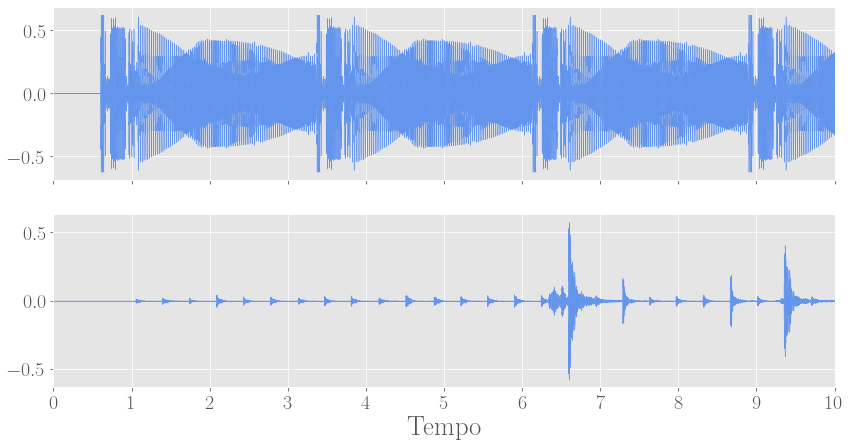

In [30]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows = lenght_S, sharex = True, figsize=(14,7))
librosa.display.waveshow(s1, sr=sr, ax=ax[0], color = 'cornflowerblue')
#ax[0].set_title('Sinais originais', fontsize = 23)
ax[0].set(xlim=(0, 10))
ax[0].tick_params(axis='y', labelsize = 20)
ax[0].label_outer()
librosa.display.waveshow(s2, sr=sr, ax=ax[1], color = 'cornflowerblue')
ax[1].tick_params(axis='y', labelsize = 20)
ax[1].tick_params(axis='x', labelsize = 20)
ax[1].set_xlabel(xlabel = 'Tempo',fontsize = 27)
ax[1].label_outer()
#plt.savefig('s_originais2.pdf')

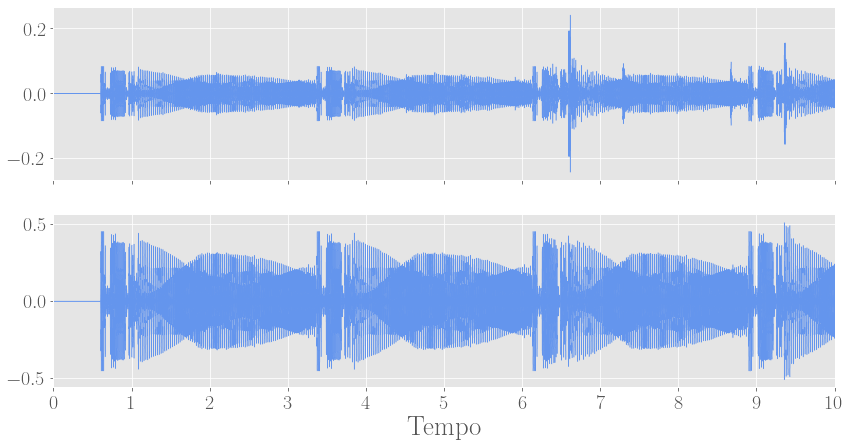

In [31]:
#fig2 = plt.figure(figsize=(10,9))
#plt.figure(figsize = (26,12))
plt.style.use('ggplot')
fig2, ax2 = plt.subplots(nrows = lenght_S, sharex = True, figsize=(14,7))
librosa.display.waveshow(X[0], sr=sr, ax=ax2[0], color = 'cornflowerblue')
#ax2[0].set_title('Sinais misturados', fontsize = 23)
ax2[0].set(xlim=(0, 10))
ax2[0].tick_params(axis='y', labelsize = 20)
ax2[0].label_outer()
librosa.display.waveshow(X[1], sr=sr, ax=ax2[1], color = 'cornflowerblue')
#ax2[1].set(title='Envelope view, stereo')
ax2[1].tick_params(axis='y', labelsize = 20)
ax2[1].tick_params(axis='x', labelsize = 20)
ax2[1].set_xlabel(xlabel = 'Tempo',fontsize = 27)
ax2[1].label_outer()
#plt.savefig('x_misturados2.pdf')

0.6046450008679976
0.9970915394147317
-0.0762132667424809
0.07621326674248087
0.9970915394147317
Número de iterações: 3
Nome do algoritmo: FastICA por Negentropia
O índice de Amari obtido para W é de 0.13682618016916237
Correlação de Pearson vale 0.014345733021257218 entre a 1 linha de S e a 1 linha de Y
Correlação de Pearson vale -0.99989709467729 entre a 1 linha de S e a 2 linha de Y
Correlação de Pearson vale 0.9999983220418351 entre a 2 linha de S e a 1 linha de Y
Correlação de Pearson vale -0.0018319152595371556 entre a 2 linha de S e a 2 linha de Y
O erro quadrático médio entre a 1ª linha de S e a 2ª linha de Y é de 0.0002121818398795553
O erro quadrático médio entre a 2ª linha de S e a 1ª linha de Y é de 0.00021899879450938903
SDR: [36.74728492 36.59581106]
SIR: [36.88116123 54.33044902]
SAR: [51.92574769 36.66961833]



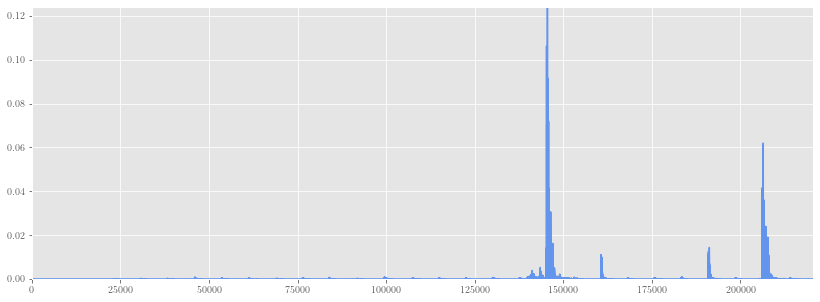

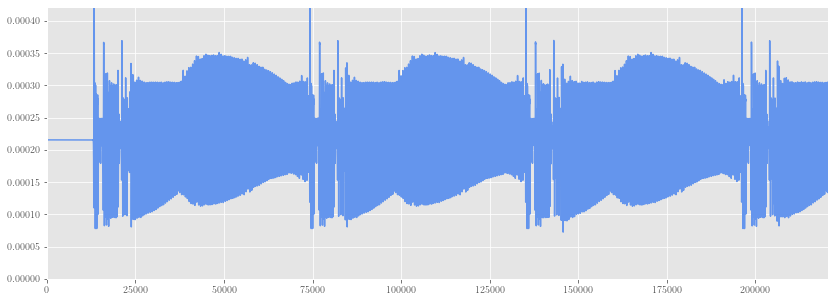

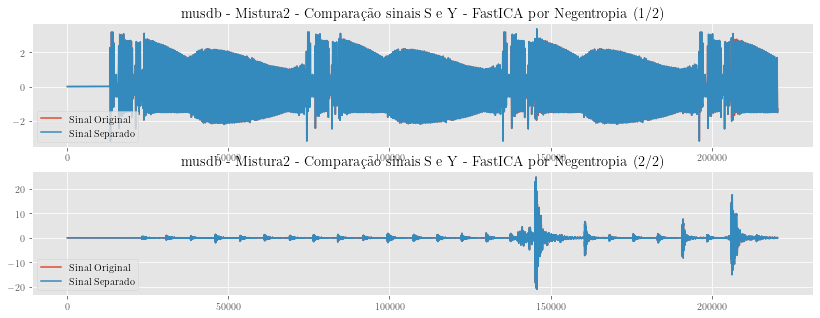

In [97]:
yn,pares , mseg= teste(tipo, arquivo1, S, X, negentropia, w, A,save = False, white = True, path_to_csv = '')

[[ 9.99999749e-01 -1.61356627e-05]
 [ 4.15313778e-07 -1.29055022e-08]]
[9.98301928e-01 2.51277604e-05]
[-0.05824739  0.0007078 ]
[ 0.0518455  -0.03121404]
[ 0.47251425 -0.87924286]
Número de iterações: 4
Nome do algoritmo: FastICA por Curtose
O índice de Amari obtido para W é de 0.45600682069632326
Correlação de Pearson vale -0.0036606119600532637 entre a 1 linha de S e a 1 linha de Y
Correlação de Pearson vale -0.9988794613256958 entre a 1 linha de S e a 2 linha de Y
Correlação de Pearson vale -0.9998691886883311 entre a 2 linha de S e a 1 linha de Y
Correlação de Pearson vale -0.03482308940309514 entre a 2 linha de S e a 2 linha de Y
O erro quadrático médio entre a 1ª linha de S e a 2ª linha de Y é de 0.00224998227005094
O erro quadrático médio entre a 2ª linha de S e a 1ª linha de Y é de 0.000477425798005817
SDR: [26.48628027 33.21887033]
SIR: [26.50394783 35.85142669]
SAR: [50.4108918  36.64405544]



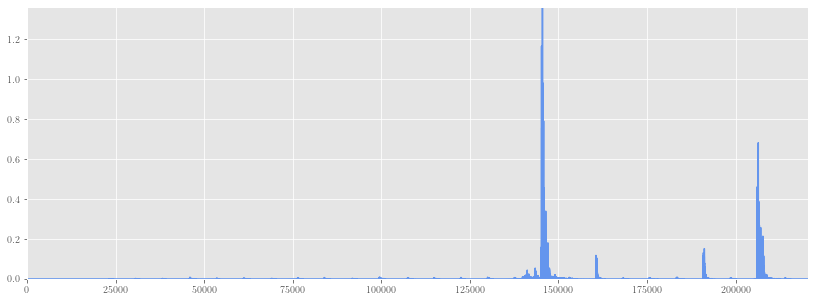

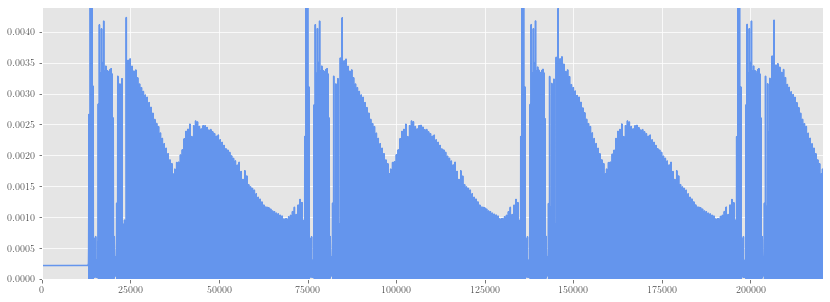

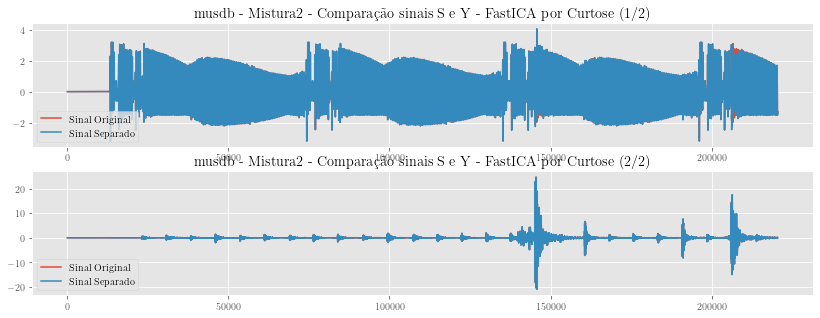

In [89]:
yn,pares , mseg= teste(tipo, arquivo1, S, X, curtose, w, A,save = False, white = True, path_to_csv = '')

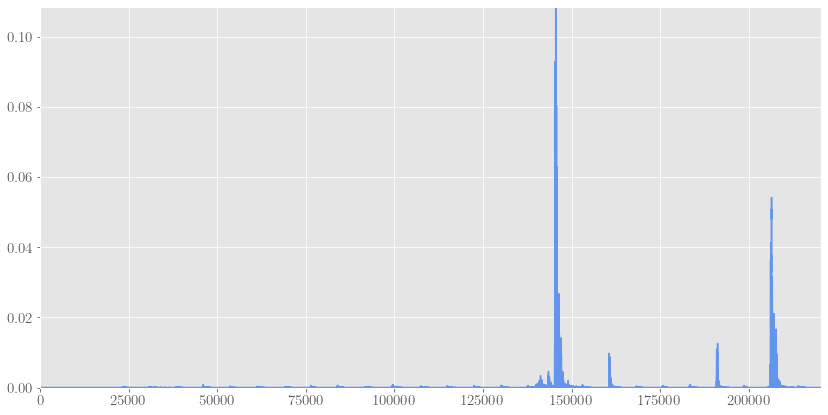

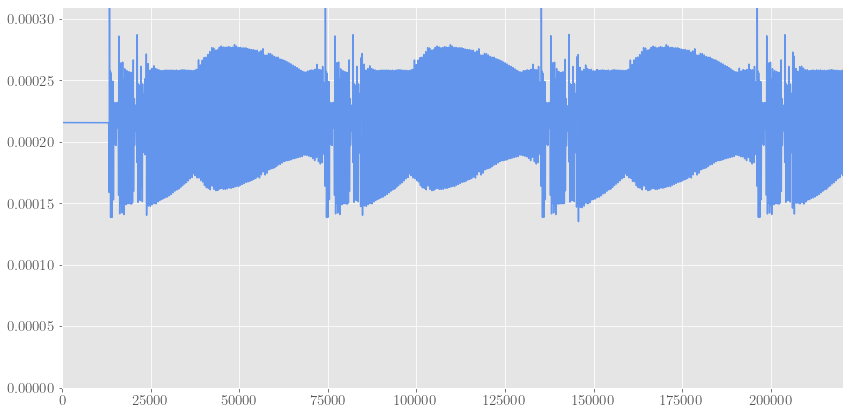

In [44]:

for graf in range (0, len(mseg)):
    plt.figure(figsize = (14,7))
    #plt.title(f'Erro quadrático médio')
    plt.xlim(0,len(S[0]))
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylim(0,  max(mseg[graf]))
    plt.plot(mseg[graf], color = 'cornflowerblue')

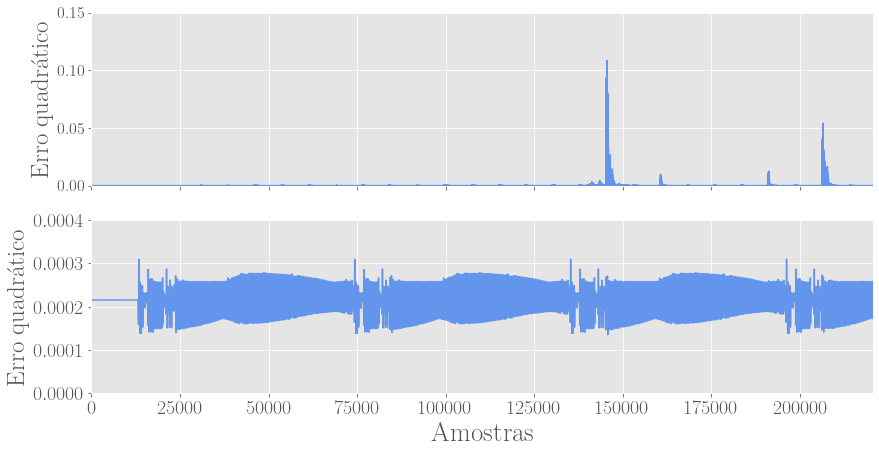

In [48]:
plt.style.use('ggplot')
mseg = np.array(mseg)
fig3, ax3 = plt.subplots(nrows = lenght_S, sharex = True, figsize=(14,7))
ax3[0].set_ylim(0,0.15)
ax3[0].plot(mseg[0], color = 'cornflowerblue')
ax3[0].tick_params(axis='y', labelsize = 16)
ax3[0].set_ylabel('Erro quadrático', fontsize = 25)
ax[0].label_outer()
ax3[1].plot(mseg[1], color = 'cornflowerblue')
ax3[1].set_ylabel('Erro quadrático', fontsize = 25)
ax3[1].set_ylim(0,0.0004)
ax3[1].set(xlim=(0,len(S[0])))
ax[1].label_outer()
ax3[1].tick_params(axis='y', labelsize = 20)
ax3[1].tick_params(axis='x', labelsize = 20)
ax3[1].set_xlabel(xlabel = 'Amostras',fontsize = 27)
plt.savefig('mse.pdf')